In [15]:
# 📌 1. Importations
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib


In [16]:
# 📌 2. Génération des données clients simulées
n_clients = 250
validated_ratio = 0.75
n_validated = int(n_clients * validated_ratio)
n_non_validated = n_clients - n_validated

def generate_client(validated=True):
    age = random.randint(28, 52)
    revenu_mensuel = random.randint(100_000, 1_000_000)
    charge_mensuelle = random.randint(20_000, int(revenu_mensuel * 0.7))
    cashflow = round(0.7 * (revenu_mensuel - charge_mensuelle))
    durée = random.randint(6, 24)
    montant_demandé = random.randint(100_000, 15_000_000)

    if validated:
        garantie = random.choice(["personnelle", "réelle"])
        while cashflow * durée < montant_demandé:
            montant_demandé = random.randint(100_000, int(cashflow * durée * 0.9))
        statut = "validé"
    else:
        garantie = "aucune" if random.random() < 0.5 else random.choice(["personnelle", "réelle"])
        montant_demandé = random.randint(int(cashflow * durée * 1.1), int(cashflow * durée * 1.5))
        statut = "non validé"

    return {
        "Âge": age,
        "Revenu mensuel": revenu_mensuel,
        "Charge mensuelle": charge_mensuelle,
        "Cashflow (70%)": cashflow,
        "Montant demandé": montant_demandé,
        "Durée (mois)": durée,
        "Garantie": garantie,
        "Statut": statut
    }

clients = [generate_client(True) for _ in range(n_validated)] + \
          [generate_client(False) for _ in range(n_non_validated)]

random.shuffle(clients)
df = pd.DataFrame(clients)
df.head(30)


,Âge,Revenu mensuel,Charge mensuelle,Cashflow (70%),Montant demandé,Durée (mois),Garantie,Statut
0,34,909577,349438,392097,4242942,19,personnelle,validé
1,51,349860,197174,106880,851796,7,personnelle,non validé
2,42,618230,261450,249746,6673166,24,personnelle,non validé
3,33,410809,75314,234846,299504,11,personnelle,validé
4,46,392663,245349,103120,872621,13,réelle,validé
5,46,927969,275240,456910,12350489,21,personnelle,non validé
6,36,100897,26907,51793,357891,18,réelle,validé
7,40,453961,144259,216791,2040418,21,personnelle,validé
8,44,766027,515252,175542,137549,23,réelle,validé
9,30,331531,168862,113868,913044,21,réelle,validé


In [17]:
# 📌 3. Encodage des variables
df["Statut_enc"] = df["Statut"].map({"validé": 0, "non validé": 1})
df["Garantie_enc"] = df["Garantie"].map({"aucune": 0, "personnelle": 1, "réelle": 2})


In [18]:
# 📌 4. Séparation des variables explicatives et cible
features = ["Âge", "Revenu mensuel", "Charge mensuelle", "Cashflow (70%)",
            "Montant demandé", "Durée (mois)", "Garantie_enc"]
target = "Statut_enc"

X = df[features]
y = df[target]


In [19]:
# 📌 5. Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)


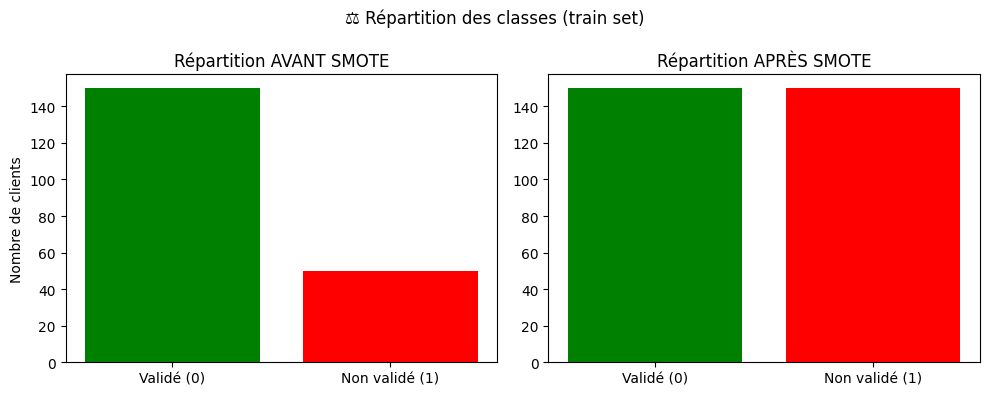

In [20]:
import matplotlib.pyplot as plt

# 📊 Visualisation de la distribution AVANT SMOTE
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(["Validé (0)", "Non validé (1)"], y_train.value_counts().sort_index(), color=["green", "red"])
ax[0].set_title("Répartition AVANT SMOTE")
ax[0].set_ylabel("Nombre de clients")

# 📈 SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 📊 Visualisation APRÈS SMOTE
ax[1].bar(["Validé (0)", "Non validé (1)"], pd.Series(y_train_resampled).value_counts().sort_index(), color=["green", "red"])
ax[1].set_title("Répartition APRÈS SMOTE")

plt.suptitle("⚖️ Répartition des classes (train set)")
plt.tight_layout()
plt.show()


In [21]:
# 📌 6. Équilibrage du jeu d'entraînement avec SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ Répartition après SMOTE :")
print(pd.Series(y_train_resampled).value_counts())


✅ Répartition après SMOTE :
Statut_enc
0    150
1    150
Name: count, dtype: int64


In [22]:
# 📌 7. Entraînement du modèle Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [23]:
# 📌 8. Évaluation sur le jeu de test
y_pred = model.predict(X_test)
print("📊 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("\n🧾 Rapport de classification :")
print(classification_report(y_test, y_pred))


📊 Matrice de confusion :
[[37  0]
 [ 1 12]]

🧾 Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       1.00      0.92      0.96        13

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.97        50
weighted avg       0.98      0.98      0.98        50



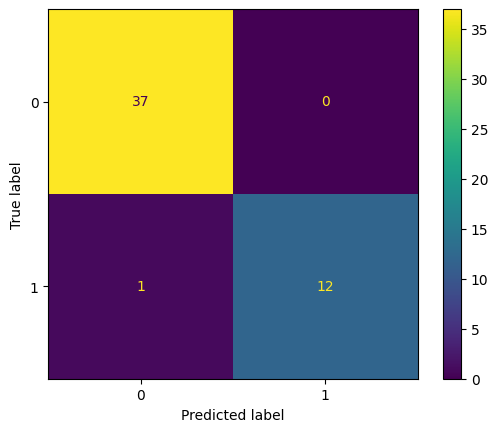

In [24]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix )
cm_display.plot()
plt.show()

In [25]:
# 📌 9. Sauvegarde du modèle
joblib.dump(model, "modele_rf1.joblib")
print("✅ Modèle sauvegardé dans 'modele_rf1.joblib'")


✅ Modèle sauvegardé dans 'modele_rf1.joblib'


In [26]:
# 📌 10. Export des données générées
df.to_excel("Clients_microfinance.xlsx", index=False)
print("✅ Données exportées sous 'Clients_microfinance.xlsx'")


✅ Données exportées sous 'Clients_microfinance.xlsx'


In [27]:
# 📌 11. Prédiction manuelle d’un nouveau client
model = joblib.load("modele_rf1.joblib")

nouveau_client = {
    "Âge": 35,
    "Revenu mensuel": 300000,
    "Charge mensuelle": 100000,
    "Cashflow (70%)": 0.7 * (300000 - 100000),
    "Montant demandé": 2000000,
    "Durée (mois)": 12,
    "Garantie_enc": 1  # 0 = aucune, 1 = personnelle, 2 = réelle
}

client_df = pd.DataFrame([nouveau_client])
prediction = model.predict(client_df)[0]
proba = model.predict_proba(client_df)[0][1]

if prediction == 0:
    print("✅ Crédit validé")
else:
    print("❌ Crédit non validé")

print(f"📈 Probabilité de refus : {round(proba*100, 2)}%")


❌ Crédit non validé
📈 Probabilité de refus : 55.0%
